<a href="https://colab.research.google.com/github/tomasonjo/blogs/blob/master/llm/text_embedding_limitations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install --quiet neo4j langchain-community langchain-openai langgraph

In [1]:
import os
import re
from langchain_community.graphs import Neo4jGraph
from langchain_community.vectorstores import Neo4jVector
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
import getpass
from pydantic import BaseModel, Field
from typing import Optional, Dict, List
from langchain_core.tools import tool

from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# Limitations of text embeddings in RAG applications
## And how to overcome them using knowledge graphs and structured tools

Everyone loves text embedding models, and for good reason — they excel at encoding unstructured text, making it easier to discover semantically similar content. It’s no surprise that they form the backbone of most RAG applications, especially with the current emphasis on encoding and retrieving relevant information from documents and other textual resources. However, there are clear examples of questions one might ask where text embedding approach to RAG applications falls short and delivers incorrect information.

As mentioned, text embeddings are great at encoding unstructured text. On the other hand, they aren’t that great at dealing with structured information and operations such as filtering, sorting, or aggregations. Imagine a simple question like:

_What is the highest-rated movie released in 2024?_

To answer this question, we must first filter by release year, followed by sorting by rating. We’ll examine how a naive approach with text embeddings performs and then demonstrate how to deal with such questions. This blog post showcases that when dealing with structured data operations such as sorting, filtering, or aggregating, you need to use tools different from text embeddings.

The code is available on GitHub.

## Environment setup
In this blog post, we will use the [recommendations project in Neo4j Sandbox](https://sandbox.neo4j.com/?usecase=recommendations). The recommendations project uses the MovieLens dataset, which contains movies, actors, ratings, and more information.

The following code will instantiate a LangChain wrapper to connect to Neo4j Database.

In [2]:
os.environ["NEO4J_URI"] = "bolt://52.70.37.100:7687"
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "challenge-armament-recoveries"

graph = Neo4jGraph(refresh_schema=False)

/Users/tomazbratanic/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Additionally, you will require an OpenAI api key that you pass in the following code:

In [3]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

OpenAI API Key: ········


The database contains 10,000 movies, but text embeddings are not yet stored. To avoid calculating embeddings for all of them, we’ll tag the 1000 top-rated films with a secondary label called Target.

In [4]:
graph.query("""
MATCH (m:Movie)
WHERE m.imdbRating IS NOT NULL
WITH m
ORDER BY m.imdbRating DESC
LIMIT 1000
SET m:Target
""")

[]

In [5]:
graph.query("""MATCH (m:Target) RETURN m {.*, embedding: Null} LIMIT 1""")

[{'m': {'budget': 30000000,
   'movieId': '1',
   'tmdbId': '862',
   'imdbVotes': 591836,
   'runtime': 81,
   'countries': ['USA'],
   'imdbId': '0114709',
   'url': 'https://themoviedb.org/movie/862',
   'plot': "A cowboy doll is profoundly threatened and jealous when a new spaceman figure supplants him as top toy in a boy's room.",
   'released': '1995-11-22',
   'languages': ['English'],
   'imdbRating': 8.3,
   'title': 'Toy Story',
   'poster': 'https://image.tmdb.org/t/p/w440_and_h660_face/uXDfjJbdP4ijW5hWSBrPrlKpxab.jpg',
   'year': 1995,
   'embedding': None,
   'revenue': 373554033}}]

## Calculating and storing text embeddings
Deciding what to embed is an important consideration. Since we’ll be demonstrating filtering by year and sorting by rating, it wouldn’t be fair to exclude those details from the embedded text. That’s why, in this case, I chose to capture the release year, rating, title, and description of each movie.

Here is an example text we will embed for the Wolf of Wall Street movie.
```
plot: Based on the true story of Jordan Belfort, from his rise to a wealthy 
      stock-broker living the high life to his fall involving crime, corruption
      and the federal government.
title: Wolf of Wall Street, The
year: 2013
imdbRating: 8.2
```
You might say this is not a good approach to embedding structured data, and I wouldn’t argue as I don’t know the best approach. Maybe instead of key-value items, we should convert them to text or something. Let me know if you have some ideas about what might work better.

The Neo4jVector object in LangChain has a convenient method `from_existing_graph` where you can select which text properties should be encoded.

In [6]:
embedding = OpenAIEmbeddings(model="text-embedding-3-small")

neo4j_vector = Neo4jVector.from_existing_graph(
    embedding=embedding,
    index_name="movies",
    node_label="Target",
    text_node_properties=["plot", "title", "year", "imdbRating"],
    embedding_node_property="embedding",
)

In this example, we utilize OpenAI’s text-embedding-3-small model for embedding generation. We initialize the Neo4jVector object using the from_existing_graph method. The node_label parameter filters the nodes to be encoded, specifically those labeled Target. The text_node_properties parameter defines the node properties to be embedded, including plot, title, year, and imdbRating. Finally, the embedding_node_property defines the property where the generated embeddings will be stored, here designated as embedding.

In [7]:
def pretty_print(vector_results):
    for result in vector_results:
        print(result.page_content)

## The naive approach
Let’s start by trying to find a movie based on its plot or description!

In [8]:
pretty_print(
    neo4j_vector.similarity_search(
        "What is a movie where a little boy meets his hero?"
    )
)



plot: A young boy befriends a giant robot from outer space that a paranoid government agent wants to destroy.
title: Iron Giant, The
year: 1999
imdbRating: 8.0

plot: After the death of a friend, a writer recounts a boyhood journey to find the body of a missing boy.
title: Stand by Me
year: 1986
imdbRating: 8.1

plot: A young, naive boy sets out alone on the road to find his wayward mother. Soon he finds an unlikely protector in a crotchety man and the two have a series of unexpected adventures along the way.
title: Kikujiro (Kikujirô no natsu)
year: 1999
imdbRating: 7.9

plot: While home sick in bed, a young boy's grandfather reads him a story called The Princess Bride.
title: Princess Bride, The
year: 1987
imdbRating: 8.1


The results seem pretty solid overall. There’s consistently a little boy involved, though I’m not sure if he always meets his hero. Then again, the dataset only includes 1,000 movies, so the options are somewhat limited.

Now let’s try a query that requires some basic filtering.

In [9]:
pretty_print(
    neo4j_vector.similarity_search(
        "Which movies are from year 2016?"
    )
)


plot: Six short stories that explore the extremities of human behavior involving people in distress.
title: Wild Tales
year: 2014
imdbRating: 8.1

plot: A young man who survives a disaster at sea is hurtled into an epic journey of adventure and discovery. While cast away, he forms an unexpected connection with another survivor: a fearsome Bengal tiger.
title: Life of Pi
year: 2012
imdbRating: 8.0

plot: Based on the true story of Jordan Belfort, from his rise to a wealthy stock-broker living the high life to his fall involving crime, corruption and the federal government.
title: Wolf of Wall Street, The
year: 2013
imdbRating: 8.2

plot: After young Riley is uprooted from her Midwest life and moved to San Francisco, her emotions - Joy, Fear, Anger, Disgust and Sadness - conflict on how best to navigate a new city, house, and school.
title: Inside Out
year: 2015
imdbRating: 8.3


It’s funny, but not a single movie from 2016 was selected. Maybe we could get better results with different text preparation for encoding. However, text embeddings aren’t applicable here as we are dealing with a simple structured data operation where we need to filter documents, or, in this example, movies, based on a metadata property. Metadata filtering is a well-established technique, often employed to enhance the accuracy of RAG systems.

The next query we will try requires a bit of sorting.

In [10]:
pretty_print(
    neo4j_vector.similarity_search("Which movie has the highest imdb score?")
)



plot: A silent film production company and cast make a difficult transition to sound.
title: Singin' in the Rain
year: 1952
imdbRating: 8.3

plot: A film about the greatest pre-Woodstock rock music festival.
title: Monterey Pop
year: 1968
imdbRating: 8.1

plot: This movie documents the Apollo missions perhaps the most definitively of any movie under two hours. Al Reinert watched all the footage shot during the missions--over 6,000,000 feet of it, ...
title: For All Mankind
year: 1989
imdbRating: 8.2

plot: An unscrupulous movie producer uses an actress, a director and a writer to achieve success.
title: Bad and the Beautiful, The
year: 1952
imdbRating: 7.9


In [11]:
graph.query("""MATCH (m:Target) RETURN m.title AS title, m.imdbRating AS rating ORDER BY rating DESC LIMIT 4""")

[{'title': 'Band of Brothers', 'rating': 9.6},
 {'title': 'Civil War, The', 'rating': 9.5},
 {'title': 'Shawshank Redemption, The', 'rating': 9.3},
 {'title': 'Cosmos', 'rating': 9.3}]

If you’re familiar with IMDb ratings, you know there are plenty of movies scoring above 8.3. The highest-rated title in our database is actually a series — Band of Brothers — with an impressive 9.6 rating. Once again, text embeddings perform poorly when it comes to sorting results.

Let’s also evaluate a question that requires some sort of aggregation.

In [12]:
pretty_print(neo4j_vector.similarity_search("How many movies are there?"))


plot: Ten television drama films, each one based on one of the Ten Commandments.
title: Decalogue, The (Dekalog)
year: 1989
imdbRating: 9.2

plot: A documentary which challenges former Indonesian death-squad leaders to reenact their mass-killings in whichever cinematic genres they wish, including classic Hollywood crime scenarios and lavish musical numbers.
title: Act of Killing, The
year: 2012
imdbRating: 8.2

plot: A meek Hobbit and eight companions set out on a journey to destroy the One Ring and the Dark Lord Sauron.
title: Lord of the Rings: The Fellowship of the Ring, The
year: 2001
imdbRating: 8.8

plot: While Frodo and Sam edge closer to Mordor with the help of the shifty Gollum, the divided fellowship makes a stand against Sauron's new ally, Saruman, and his hordes of Isengard.
title: Lord of the Rings: The Two Towers, The
year: 2002
imdbRating: 8.7


In [13]:
graph.query("""MATCH (m:Target) RETURN count(*)""")

[{'count(*)': 1000}]

The results are definitely not helpful here as we get returned four random movies. It’s virtually impossible to get from these random four movies to conclusion that there are a total of 1000 movies we tagged and embedded for this example

So, what’s the solution? It’s straightforward: questions involving structured operations like filtering, sorting, and aggregation need tools specifically designed to operate with structured data.

## Tools for structured data
At the moment it seems that most people think about the text2query approach, where an LLM generates a database query to interact with a database based on the provided question and schema. For Neo4j specifically this is text2cypher, but there is also text2sql for SQL databases. However, it turns out in practice that it isn’t reliable and not robust enough for production use.

![image](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*01cgymtST8cG6b8C.png)

You can use techniques like chain of thought, few-shot examples, or fine-tuning, but achieving high accuracy remains nearly impossible at this stage. The text2query approach works well for simple questions on straightforward database schemas, but that’s not the reality of production environments. To address this, we shift the complexity of generating database queries away from an LLM and treat it as a code problem where we generate database queries deterministically based on function inputs. The advantage is significantly improved robustness, though it comes at the cost of reduced flexibility. It’s better to narrow the scope of the RAG application and answer those questions accurately, rather than attempt to answer everything but do so inaccurately.

Since we are generating database queries — in this case, Cypher statements — based on function inputs, we can leverage the tool capabilities of LLMs. In this process, the LLM populates the relevant parameters based on user input, while the function handles retrieving the necessary information. For this demonstration, we will first implement two tools: one for counting movies and another for listing them, and then create an LLM agent using LangGraph.

## Tool for counting movies
We will being by implementing a tool for counting movies based on predefined filters. First, we have to define what those filters are and describe to an LLM when and how to use them.

In [14]:
def extract_param_name(filter: str) -> str:
    # Regex to find parameters in the Cypher statement
    pattern = r'\$\w+'
    # Search for the first match
    match = re.search(pattern, filter)
    
    # Output the first found parameter, if it exists
    if match:
        return match.group()[1:]
    return None

In [ ]:
class MovieCountInput(BaseModel):
    min_year: Optional[int] = Field(
        description="Minimum release year of the movies"
    )
    max_year: Optional[int] = Field(
        description="Maximum release year of the movies"
    )
    min_rating: Optional[float] = Field(description="Minimum imdb rating")
    grouping_key: Optional[str] = Field(
        description="The key to group by the aggregation", enum=["year"]
    )

LangChain offers several ways to define function inputs, but I prefer the Pydantic approach. In this example, we have three filters available to refine movie results: min_year, max_year, and min_rating. These filters are based on structured data and are all optional, as the user may choose to include any, all, or none of them. Additionally, we've introduced a grouping_key input that tells the function whether to group the count by a specific property. In this case, the only supported grouping is by year, as defined in the enumsection.

Now let’s define the actual function

In [15]:
@tool("movie-count", args_schema=MovieCountInput)
def movie_count(
    min_year: Optional[int],
    max_year: Optional[int],
    min_rating: Optional[float],
    grouping_key: Optional[str],
) -> List[Dict]:
    """Calculate the count of movies based on particular filters"""

    filters = [
        ("t.year >= $min_year", min_year),
        ("t.year <= $max_year", max_year),
        ("t.imdbRating >= $min_rating", min_rating),
    ]

    # Create the parameters dynamically from function inputs
    params = {
        extract_param_name(condition): value
        for condition, value in filters
        if value is not None
    }
    where_clause = " AND ".join(
        [condition for condition, value in filters if value is not None]
    )

    cypher_statement = "MATCH (t:Target) "
    if where_clause:
        cypher_statement += f"WHERE {where_clause} "

    return_clause = (
        f"t.`{grouping_key}`, count(t) AS movie_count"
        if grouping_key
        else "count(t) AS movie_count"
    )

    cypher_statement += f"RETURN {return_clause}"

    print(cypher_statement)  # Debugging output
    return graph.query(cypher_statement, params=params)

The movie_count function generates a Cypher query to count movies based on optional filters and grouping key. It begins by defining a list of filters with corresponding values provided as arguments. The filters are used to dynamically build the WHERE clause, which is responsible for applying the specified filtering conditions in the Cypher statement, including only those conditions where values are not None.

The RETURN clause of the Cypher query is then constructed, either grouping by the provided grouping_key or simply counting the total number of movies. Finally, the function executes the query and returns the results.

The function can be extended with more arguments and more involved logic as needed, but it’s important to ensure it remains clear so that an LLM can call it correctly and accurately.

## Tool for listing movies
Again, we have to start by defining arguments of the function.

In [ ]:
class MovieListInput(BaseModel):
    sort_by: str = Field(description="How to sort movies, can be one of either latest, rating", enum=['latest', 'rating'])
    k: Optional[int] = Field(description="Number of movies to return")
    description: Optional[str] = Field(description="Description of the movies")
    min_year: Optional[int] = Field(description="Minimum release year of the movies")
    max_year: Optional[int] = Field(description="Maximum release year of the movies")
    min_rating: Optional[float] = Field(description="Minimum imdb rating")

We keep the same three filters as in the movie count function, but we add the description argument. This argument lets us search and list movies based on their plot using vector similarity search. Just because we’re using structured tools and filters doesn’t mean we can’t incorporate text embedding and vector search methods. Since we don’t want to return all movies most of the time, we include an optional k input with a default value. Additionally, for listing, we want to sort the movies to return only the most relevant ones. In this case, we can sort them by rating or release year.

Let’s now implement the function.

In [16]:
@tool("movie-list", args_schema=MovieListInput)
def movie_list(
    sort_by: str = "rating",
    k : int = 4,
    description: Optional[str] = None,
    min_year: Optional[int] = None,
    max_year: Optional[int] = None,
    min_rating: Optional[float] = None,
) -> List[Dict]:
    """List movies based on particular filters"""

    # Handle vector-only search when no prefiltering is applied
    if description and not min_year and not max_year and not min_rating:
        return neo4j_vector.similarity_search(description, k=k)

    filters = [
        ("t.year >= $min_year", min_year),
        ("t.year <= $max_year", max_year),
        ("t.imdbRating >= $min_rating", min_rating),
    ]

    # Create parameters dynamically from function arguments
    params = {
        key.split("$")[1]: value for key, value in filters if value is not None
    }
    where_clause = " AND ".join(
        [condition for condition, value in filters if value is not None]
    )

    cypher_statement = "MATCH (t:Target) "
    if where_clause:
        cypher_statement += f"WHERE {where_clause} "

    # Add the return clause with sorting
    cypher_statement += " RETURN t.title AS title, t.year AS year, t.imdbRating AS rating ORDER BY "

    # Handle sorting logic based on description or other criteria
    if description:
        cypher_statement += (
            "vector.similarity.cosine(t.embedding, $embedding) DESC "
        )
        params["embedding"] = embedding.embed_query(description)
    elif sort_by == "rating":
        cypher_statement += "t.imdbRating DESC "
    else:  # sort by latest year
        cypher_statement += "t.year DESC "

    cypher_statement += " LIMIT toInteger($limit)"
    params["limit"] = k or 4

    print(cypher_statement)  # Debugging output
    data = graph.query(cypher_statement, params=params)
    return data

This function retrieves a list of movies based on multiple optional filters: description, year range, minimum rating, and sorting preferences. If only a description is given with no other filters, it performs a vector index similarity search to find relevant movies. When additional filters are applied, the function constructs a Cypher query to match movies based on the specified criteria, such as release year and IMDb rating, combining them with an optional description-based similarity. The results are then sorted by either the similarity score, IMDb rating, or year, and limited to k movies.

## Putting it all together as a LangGraph agent
We will implement a straightforward ReAct agent using LangGraph.

The agent consists of an LLM and tools step. As we interact with the agent, we will first call the LLM to decide if we should use tools. Then we will run a loop:

* If the agent said to take an action (i.e. call tool), we’ll run the tools and pass the results back to the agent
* If the agent did not ask to run tools, we will finish (respond to the user)

The code implementation is as straightforward as it gets. First we bind the tools to the LLM and define the assistant step.

In [17]:
llm = ChatOpenAI(model='gpt-4-turbo')

tools = [movie_count, movie_list]
llm_with_tools = llm.bind_tools(tools)

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with finding and explaining relevant information about movies.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

Next we define the LangGraph flow.

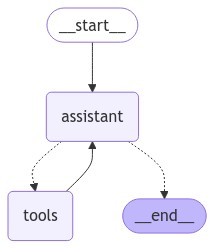

In [18]:
# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

We define two nodes in the LangGraph and link them with a conditional edge. If a tool is called, the flow is directed to the tools; otherwise, the results are sent back to the user.

Let’s now test our agent.

In [19]:
messages = [
    HumanMessage(
        content="What are the some movies about a girl meeting her hero?"
    )
]
messages = react_graph.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

What are the some movies about a girl meeting her hero?
================================== Ai Message ==================================
Tool Calls:
  movie-list (call_LbXxiTRavkwgPArhDpFi9N1g)
 Call ID: call_LbXxiTRavkwgPArhDpFi9N1g
  Args:
    description: girl meets her hero
    sort_by: rating
    k: 5
    min_year: None
    max_year: None
    min_rating: None
================================= Tool Message =================================
Name: movie-list

[Document(metadata={'movieId': '57504', 'tmdbId': '14069', 'imdbVotes': 33731, 'runtime': 98, 'countries': ['Japan'], 'imdbId': '0808506', 'url': 'https://themoviedb.org/movie/14069', 'released': '2006-07-15', 'languages': ['Japanese'], 'poster': 'https://image.tmdb.org/t/p/w440_and_h660_face/7oNeWrsaiMGxCrvkWjQ56y6JN85.jpg', 'revenue': 3800000}, page_content='\nplot: A high-school girl acquires the ability to time travel.\ntitle: Girl Who Leapt Th

In [20]:
messages = [
    HumanMessage(
        content="What are the movies from the 90s about a girl meeting her hero?"
    )
]
messages = react_graph.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

MATCH (t:Target) WHERE t.year >= $min_year AND t.year <= $max_year  RETURN t.title AS title, t.year AS year, t.imdbRating AS rating ORDER BY vector.similarity.cosine(t.embedding, $embedding) DESC  LIMIT toInteger($limit)
================================ Human Message =================================

What are the movies from the 90s about a girl meeting her hero?
================================== Ai Message ==================================
Tool Calls:
  movie-list (call_cG8GU8i3xciFG40vo9GSvNql)
 Call ID: call_cG8GU8i3xciFG40vo9GSvNql
  Args:
    description: girl meeting her hero
    min_year: 1990
    max_year: 1999
    sort_by: latest
    k: None
    min_rating: None
================================= Tool Message =================================
Name: movie-list

[{"title": "Whisper of the Heart (Mimi wo sumaseba)", "year": 1995, "rating": 8.0}, {"title": "Léon: The Professional (a.k.a. The Professional) (Léon)", "year": 1994, "rating": 8.6}, {"title": "Breaking the Waves", "ye

In [21]:
messages = [
    HumanMessage(
        content="How many movies are from the 90s have the rating higher than 9.1?"
    )
]
messages = react_graph.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()


MATCH (t:Target) WHERE t.year >= $min_year AND t.year <= $max_year AND t.imdbRating >= $min_rating RETURN count(t) AS movie_count
================================ Human Message =================================

How many movies are from the 90s have the rating higher than 9.1?
================================== Ai Message ==================================
Tool Calls:
  movie-count (call_fLRtZRwlPic0w5w111wJIrcP)
 Call ID: call_fLRtZRwlPic0w5w111wJIrcP
  Args:
    min_year: 1990
    max_year: 1999
    min_rating: 9.1
    grouping_key: None
================================= Tool Message =================================
Name: movie-count

[{"movie_count": 3}]
================================== Ai Message ==================================

There are 3 movies from the 1990s with an IMDb rating higher than 9.1.


In [22]:
messages = [
    HumanMessage(
        content="How many were movies released per year made after the highest rated movie?"
    )
]
messages = react_graph.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

MATCH (t:Target)  RETURN t.title AS title, t.year AS year, t.imdbRating AS rating ORDER BY t.imdbRating DESC  LIMIT toInteger($limit)
MATCH (t:Target) WHERE t.year >= $min_year RETURN t.`year`, count(t) AS movie_count
================================ Human Message =================================

How many were movies released per year made after the highest rated movie?
================================== Ai Message ==================================
Tool Calls:
  movie-list (call_YWmf0oSM1JYWSfZpChqswH1r)
 Call ID: call_YWmf0oSM1JYWSfZpChqswH1r
  Args:
    sort_by: rating
    k: 1
    description: None
    min_year: None
    max_year: None
    min_rating: None
================================= Tool Message =================================
Name: movie-list

[{"title": "Band of Brothers", "year": 2001, "rating": 9.6}]
================================== Ai Message ==================================
Tool Calls:
  movie-count (call_C9HCC1iEBmYkGOuIeINEFssj)
 Call ID: call_C9HCC1iEBmYkGOu